In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('google_taxi_fares/Data/NYCTaxiFares.csv')

In [17]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [18]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [19]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [20]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [21]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [22]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [23]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1).astype(np.int64)

In [24]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [25]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[1.0000, 2.1263],
        [1.0000, 1.3923],
        [2.0000, 3.3268],
        [1.0000, 1.8641],
        [1.0000, 7.2313]])

In [26]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [28]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [29]:
try:
    model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4).cuda()
except:
    print('Cuda not available, model\'s device: CPU')
    model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [30]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
batch_size = 60000
test_size = int(batch_size * .2)

try:
    cat_train = cats[:batch_size-test_size].cuda()
    cat_test = cats[batch_size-test_size:batch_size].cuda()
    con_train = conts[:batch_size-test_size].cuda()
    con_test = conts[batch_size-test_size:batch_size].cuda()
    y_train = y[:batch_size-test_size].cuda()
    y_test = y[batch_size-test_size:batch_size].cuda()
except:
    print('CUDA not available, setting the tensors\' device to CPU')
    cat_train = cats[:batch_size-test_size]
    cat_test = cats[batch_size-test_size:batch_size]
    con_train = conts[:batch_size-test_size]
    con_test = conts[batch_size-test_size:batch_size]
    y_train = y[:batch_size-test_size]
    y_test = y[batch_size-test_size:batch_size]

In [32]:
import time
start_time = time.time()

epochs = 300
losses = []

if torch.cuda.is_available:
    print('Training on the GPU')

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Training on the GPU
epoch:   1  loss: 12.59068584
epoch:  26  loss: 10.79177570
epoch:  51  loss: 10.22422981
epoch:  76  loss: 9.83793926
epoch: 101  loss: 9.35941124
epoch: 126  loss: 8.67290115
epoch: 151  loss: 7.69670105
epoch: 176  loss: 6.53842068
epoch: 201  loss: 5.33328104
epoch: 226  loss: 4.43261147
epoch: 251  loss: 4.04701519
epoch: 276  loss: 3.93350577
epoch: 300  loss: 3.90340829

Duration: 17 seconds


Text(0.5, 0, 'epoch')

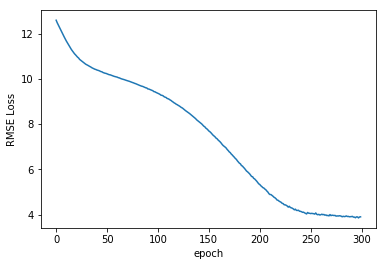

In [33]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [34]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.78308892


In [35]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   5.4037   2.9000   2.5037
 2.  18.6131   5.7000  12.9131
 3.   7.8249   7.7000   0.1249
 4.  14.4169  12.5000   1.9169
 5.   4.0076   4.1000   0.0924
 6.   7.6967   5.3000   2.3967
 7.   4.6546   3.7000   0.9546
 8.  17.9663  14.5000   3.4663
 9.   5.5598   5.7000   0.1402
10.   9.8906  10.1000   0.2094
11.   8.1110   4.5000   3.6110
12.   5.1563   6.1000   0.9437
13.   6.6104   6.9000   0.2896
14.  11.3122  14.1000   2.7878
15.   4.0420   4.5000   0.4580
16.  45.2746  34.1000  11.1746
17.   5.0354  12.5000   7.4646
18.   6.0539   4.1000   1.9539
19.   7.2032   8.5000   1.2968
20.   6.7409   5.3000   1.4409
21.   9.6551  11.3000   1.6449
22.   8.9049  10.5000   1.5951
23.  16.0830  15.3000   0.7830
24.  19.1344  14.9000   4.2344
25.  60.4951  49.5700  10.9251
26.   4.8605   5.3000   0.4395
27.   7.0316   3.7000   3.3316
28.   5.1919   6.5000   1.3081
29.  14.5273  14.1000   0.4273
30.   5.6448   4.9000   0.7448
31.   3.8268   3.7000   0.1268
32.  31.

In [36]:
# Make sure to save the model only after the training has happened
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [38]:
from google_taxi_fares.Data.getting_distance import get_data

In [39]:
data = get_data()

In [40]:
def test_data(data, model): # pass in the name of the new model
    # PREPROCESS THE DATA
    dfx = pd.DataFrame(data, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # Create categorical and continous tensors
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['passenger_count', 'dist_km']
    categorical = np.stack([dfx[col].values for col in cat_cols], 1)
    categorical = torch.tensor(categorical, dtype=torch.int64)
    continous = np.stack([dfx[col].values for col in cont_cols], 1).astype(np.float64)
    continous = torch.tensor(continous, dtype=torch.float)
    
    # Pass new data through the model without performing backpropagation
    model.eval()
    with torch.no_grad():
        result = model(categorical.cuda(), continous.cuda())
    print(f'\nThe predicted fare amount is ${result.item():.2f}')

In [41]:
test_data(data, model)


The predicted fare amount is $8.99


In [42]:
df = pd.DataFrame(data, index=[0])

In [43]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')

df['EDTdate'] = pd.to_datetime(df['EDTdate'])

In [44]:
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,0,1) 
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df['Weekday'] = df['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')

In [45]:
df

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,EDTdate,dist_km,Hour,AMorPM,Weekday
0,54.180542,15.573012,54.159983,15.543299,2,2020-09-27 06:55:49,2.994507,6,0,3
